In [3]:
import pandas as pd

df = pd.read_csv("/content/funnel_events_50k.csv", parse_dates=["event_time"])

df.head()


,user_id,event_time,event_type,campaign,device
0,1,2025-01-29 17:25:00,install,facebook,ios
1,1,2025-01-29 19:27:00,signup,facebook,ios
2,1,2025-01-30 03:14:00,view_product,facebook,ios
3,1,2025-01-30 23:53:00,add_to_cart,facebook,ios
4,2,2025-01-24 02:11:00,install,google,android


In [7]:
event_order = [
    "install", "signup", "view_product",
    "add_to_cart", "checkout", "purchase"
]

# Compute the first time each user performed each event
user_steps = (
    df.groupby(["user_id", "event_type"])["event_time"]
      .min()
      .reset_index()
      .pivot(index="user_id", columns="event_type", values="event_time")
      .reindex(columns=event_order)
)

user_steps.head()



event_type,install,signup,view_product,add_to_cart,checkout,purchase
user_id,,,,,,
1,2025-01-29 17:25:00,2025-01-29 19:27:00,2025-01-30 03:14:00,2025-01-30 23:53:00,NaT,NaT
2,2025-01-24 02:11:00,2025-01-25 00:24:00,NaT,NaT,NaT,NaT
3,2025-01-12 15:56:00,2025-01-12 20:33:00,2025-01-13 16:18:00,2025-01-13 23:58:00,2025-01-14 22:16:00,2025-01-14 22:38:00
4,2025-01-25 11:40:00,2025-01-26 03:56:00,NaT,NaT,NaT,NaT
5,2025-01-30 21:08:00,2025-01-31 11:00:00,2025-02-01 06:15:00,NaT,NaT,NaT


In [8]:
import numpy as np

step_counts = (~user_step_time.isna()).sum()
step_counts


,0
event_type,
install,12000
signup,12000
view_product,10777
add_to_cart,8434
checkout,4222
purchase,1871


In [28]:
import numpy as np

step_counts = (~user_steps.isna()).sum()

funnel_df = pd.DataFrame({
    "step": step_counts.index,
    "users": step_counts.values
})

# Conversion rate relative to previous step
funnel_df["conversion_rate"] = (funnel_df["users"].pct_change().fillna(1) + 1).round(4) * 100

# Drop-off percentage
funnel_df["dropoff"] = (1 - funnel_df["conversion_rate"]/100).round(4) * 100

# Set drop-off for the first step (install) to 0
funnel_df.loc[0, "dropoff"] = 0
funnel_df.loc[0, "conversion_rate"] = 0

funnel_df

,step,users,conversion_rate,dropoff
0,install,12000,0.00,0.00
1,signup,12000,100.00,0.00
2,view_product,10777,89.81,10.19
3,add_to_cart,8434,78.26,21.74
4,checkout,4222,50.06,49.94
5,purchase,1871,44.32,55.68


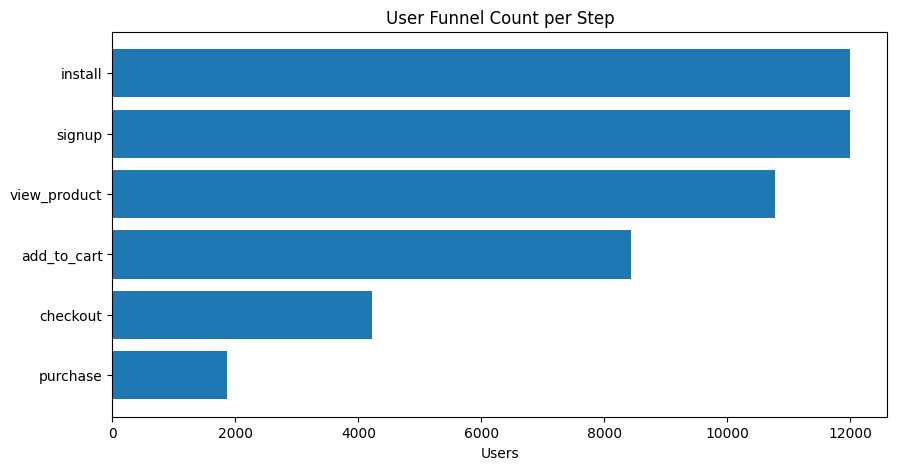

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(funnel_df["step"], funnel_df["users"])
plt.xlabel("Users")
plt.title("User Funnel Count per Step")
plt.gca().invert_yaxis()
plt.show()


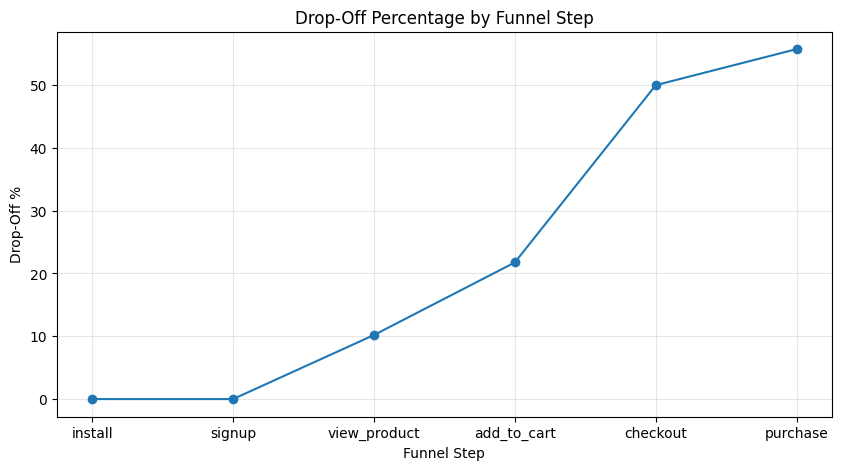

In [22]:
plt.figure(figsize=(10,5))
plt.plot(funnel_df["step"], funnel_df["dropoff"], marker="o")
plt.title("Drop-Off Percentage by Funnel Step")
plt.ylabel("Drop-Off %")
plt.xlabel("Funnel Step")
plt.grid(alpha=0.3)
plt.show()


In [24]:
# Get each user's first campaign
first_campaign = (
    df.sort_values("event_time")
      .groupby("user_id")["campaign"]
      .first()
)

user_steps_campaign = user_steps.copy()
user_steps_campaign["campaign"] = first_campaign


In [25]:
campaign_funnels = (
    user_steps_campaign
    .groupby("campaign")
    .apply(lambda x: (~x[event_order].isna()).sum())
)

campaign_funnels


/tmp/ipython-input-2636363880.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (~x[event_order].isna()).sum())


event_type,install,signup,view_product,add_to_cart,checkout,purchase
campaign,,,,,,
facebook,3046,3046,2727,2126,1090,512
google,3576,3576,3216,2507,1262,550
instagram,2366,2366,2120,1698,820,353
organic,1830,1830,1643,1281,640,269
referral,1182,1182,1071,822,410,187


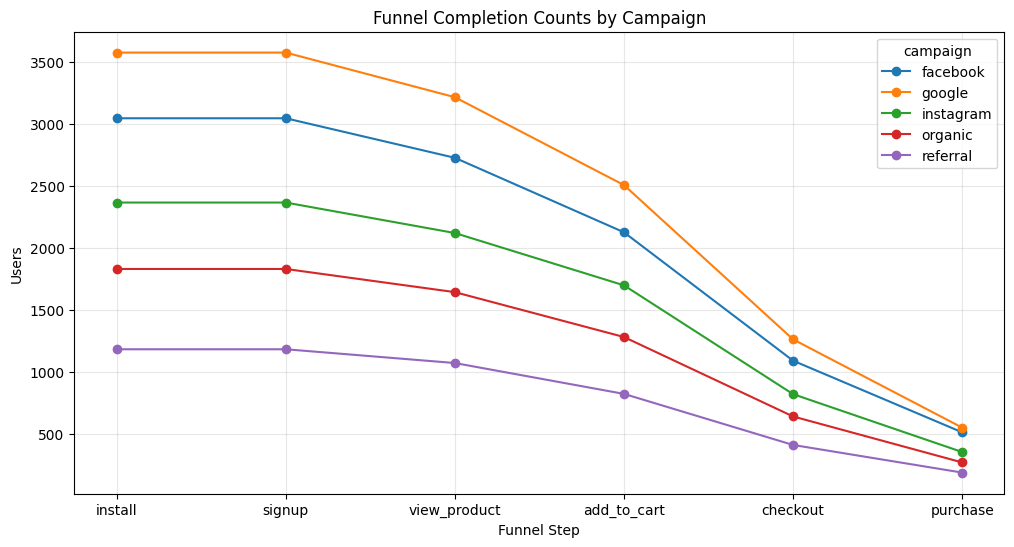

In [26]:
campaign_funnels.T.plot(
    figsize=(12,6),
    marker="o"
)
plt.title("Funnel Completion Counts by Campaign")
plt.xlabel("Funnel Step")
plt.ylabel("Users")
plt.grid(alpha=0.3)
plt.show()


In [27]:
user_steps.to_csv("clean_user_funnel.csv")
